In [1]:
import pandas as pd
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

In [2]:
operations = {
    "orf": "wellpos_cc_var_mad_outlier_featselect_sphering_harmony",
    "crispr": "wellpos_cc_var_mad_outlier_featselect_sphering_harmony_PCA_corrected",
}

In [3]:
# Read phenotypic activity

orf_phenotypic_activity_df = pd.read_csv(
    f"../03.retrieve-annotations/output/phenotypic-activity-{operations['orf']}.csv.gz",
    dtype={"below_corrected_p": bool},
)[["Metadata_JCP2022", "below_corrected_p"]]

crispr_phenotypic_activity_df = pd.read_csv(
    f"../03.retrieve-annotations/output/phenotypic-activity-{operations['crispr']}.csv.gz",
    dtype={"below_corrected_p": bool},
)[["Metadata_JCP2022", "below_corrected_p"]]

In [4]:
# Read metadata

orf_metadata_df = pd.read_csv(
    "../00.download-and-process-annotations/output/orf_metadata.tsv.gz",
    sep="\t",
    dtype={"Metadata_NCBI_Gene_ID": str},
)[["Metadata_JCP2022", "Metadata_NCBI_Gene_ID"]]

crispr_metadata_df = pd.read_csv(
    "../00.download-and-process-annotations/output/crispr_metadata.tsv.gz",
    sep="\t",
    dtype={"Metadata_NCBI_Gene_ID": str},
)[["Metadata_JCP2022", "Metadata_NCBI_Gene_ID"]]

### All genes

In [5]:
all_orf_df = orf_metadata_df.drop_duplicates("Metadata_NCBI_Gene_ID")
all_crispr_df = crispr_metadata_df.drop_duplicates("Metadata_NCBI_Gene_ID")

all_merged_df = all_orf_df.merge(
    all_crispr_df,
    on="Metadata_NCBI_Gene_ID",
    how="outer",
    suffixes=("_orf", "_crispr"),
    indicator=True,
)

all_genes = [
    all_merged_df.query("_merge=='left_only'").shape[0],
    all_merged_df.query("_merge=='right_only'").shape[0],
    all_merged_df.query("_merge=='both'").shape[0],
]
print(all_genes)

[7267, 2633, 5343]


### Only the ones with phenotypic activity

In [6]:
orf_df = (
    (
        orf_metadata_df.merge(
            orf_phenotypic_activity_df, on="Metadata_JCP2022", how="inner"
        )
    )
    .sort_values("below_corrected_p")
    .drop_duplicates("Metadata_NCBI_Gene_ID", keep="last")
)

crispr_df = crispr_metadata_df.merge(
    crispr_phenotypic_activity_df, on="Metadata_JCP2022", how="inner"
)

merged_df = orf_df.merge(
    crispr_df,
    on="Metadata_NCBI_Gene_ID",
    how="outer",
    suffixes=("_orf", "_crispr"),
    indicator=True,
)

merged_replicable_df = orf_df.query("below_corrected_p==True").merge(
    crispr_df.query("below_corrected_p==True"),
    on="Metadata_NCBI_Gene_ID",
    how="outer",
    suffixes=("_orf", "_crispr"),
    indicator=True,
)

replicable_genes = [
    merged_replicable_df.query("_merge=='left_only'").shape[0],
    merged_replicable_df.query("_merge=='right_only'").shape[0],
    merged_replicable_df.query("_merge=='both'").shape[0],
]
print(replicable_genes)

[4806, 3321, 2225]


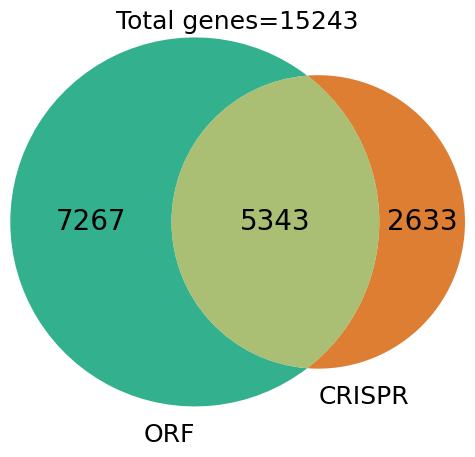

In [7]:
fig = venn2(
    all_genes,
    set_labels=("ORF", "CRISPR"),
    set_colors=("#009e73", "#d55e00"),
    alpha=0.8,
    normalize_to=sum(all_genes),
)

for text in fig.set_labels:
    text.set_fontsize(18)
for text in fig.subset_labels:
    text.set_fontsize(20)

plt.title(f"Total genes={sum(all_genes)}", fontsize=18)
plt.savefig("figures/all-orf-and-crispr-venn.png", dpi=300, transparent=True)
plt.savefig("figures/all-orf-and-crispr-venn.svg", dpi=300, transparent=True)

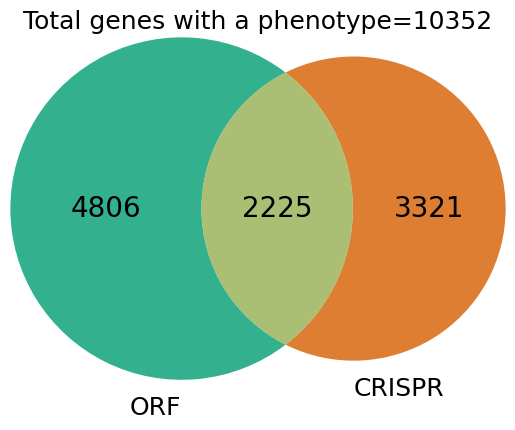

In [8]:
fig = venn2(
    replicable_genes,
    set_labels=("ORF", "CRISPR"),
    set_colors=("#009e73", "#d55e00"),
    alpha=0.8,
    normalize_to=sum(replicable_genes),
)

for text in fig.set_labels:
    text.set_fontsize(18)
for text in fig.subset_labels:
    text.set_fontsize(20)

plt.title(f"Total genes with a phenotype={sum(replicable_genes)}", fontsize=18)
plt.savefig("figures/replicable-orf-and-crispr-venn.png", dpi=300, transparent=True)
plt.savefig("figures/replicable-orf-and-crispr-venn.svg", dpi=300, transparent=True)